# Doing Bayesian Data Analysis

An example from __Chapter 18__.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
from scipy import stats as st

from utils import plt, sns

In [2]:
df = pd.read_csv("../data/Guber1999data.csv")
print len(df)
df.head()

50


,State,Spend,StuTeaRat,Salary,PrcntTake,SATV,SATM,SATT
0,Alabama,4.405,17.2,31.144,8,491,538,1029
1,Alaska,8.963,17.6,47.951,47,445,489,934
2,Arizona,4.778,19.3,32.175,27,448,496,944
3,Arkansas,4.459,17.1,28.934,6,482,523,1005
4,California,4.992,24.0,41.078,45,417,485,902


In [4]:
X = df[["Spend", "PrcntTake"]]
y = df["SATT"]

# A little bit convoluted with the two columns
zx = ((X - X.mean().values) / X.std().values).values
zy = (y - y.mean()) / y.std()

In [5]:
n_cols = 2
with pm.Model() as model:
    # Priors
    beta_0 = pm.Normal("beta_0", mu=0, tau=1E-8)
    beta_1 = pm.Normal("beta_1", mu=0, tau=1E-8, shape=n_cols)
    theta = beta_0 + tt.dot(beta_1, zx.T)

    sigma = pm.HalfCauchy("sigma", 5)     # Gelman 2006
    nu = pm.Exponential("nu", 1.0 / 29)   # Taken from the book
    # Likelihood
    y = pm.StudentT("y", nu=nu, mu=theta, sd=sigma, observed=zy)
    # Sample
    trace = pm.sample(draws=6000, tune=1000, chain=3)
    
burn_in = 2000
trace = trace[burn_in:]

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -68.243: 100%|██████████| 200000/200000 [00:19<00:00, 10523.20it/s]
Finished [100%]: Average ELBO = -68.245
100%|██████████| 6000/6000 [00:08<00:00, 690.22it/s]


                mean         sd  mc_error   hpd_2.5   hpd_97.5
beta_0      0.000263   0.062089  0.001065 -0.116622   0.130391
beta_1__0   0.231514   0.077951  0.001626  0.070278   0.374882
beta_1__1  -1.029433   0.078098  0.001779 -1.180942  -0.876256
sigma       0.418685   0.052834  0.001112  0.323099   0.529794
nu         33.119533  28.512963  0.532801  1.944652  91.057368


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x111588350>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x110b8f590>]], dtype=object)

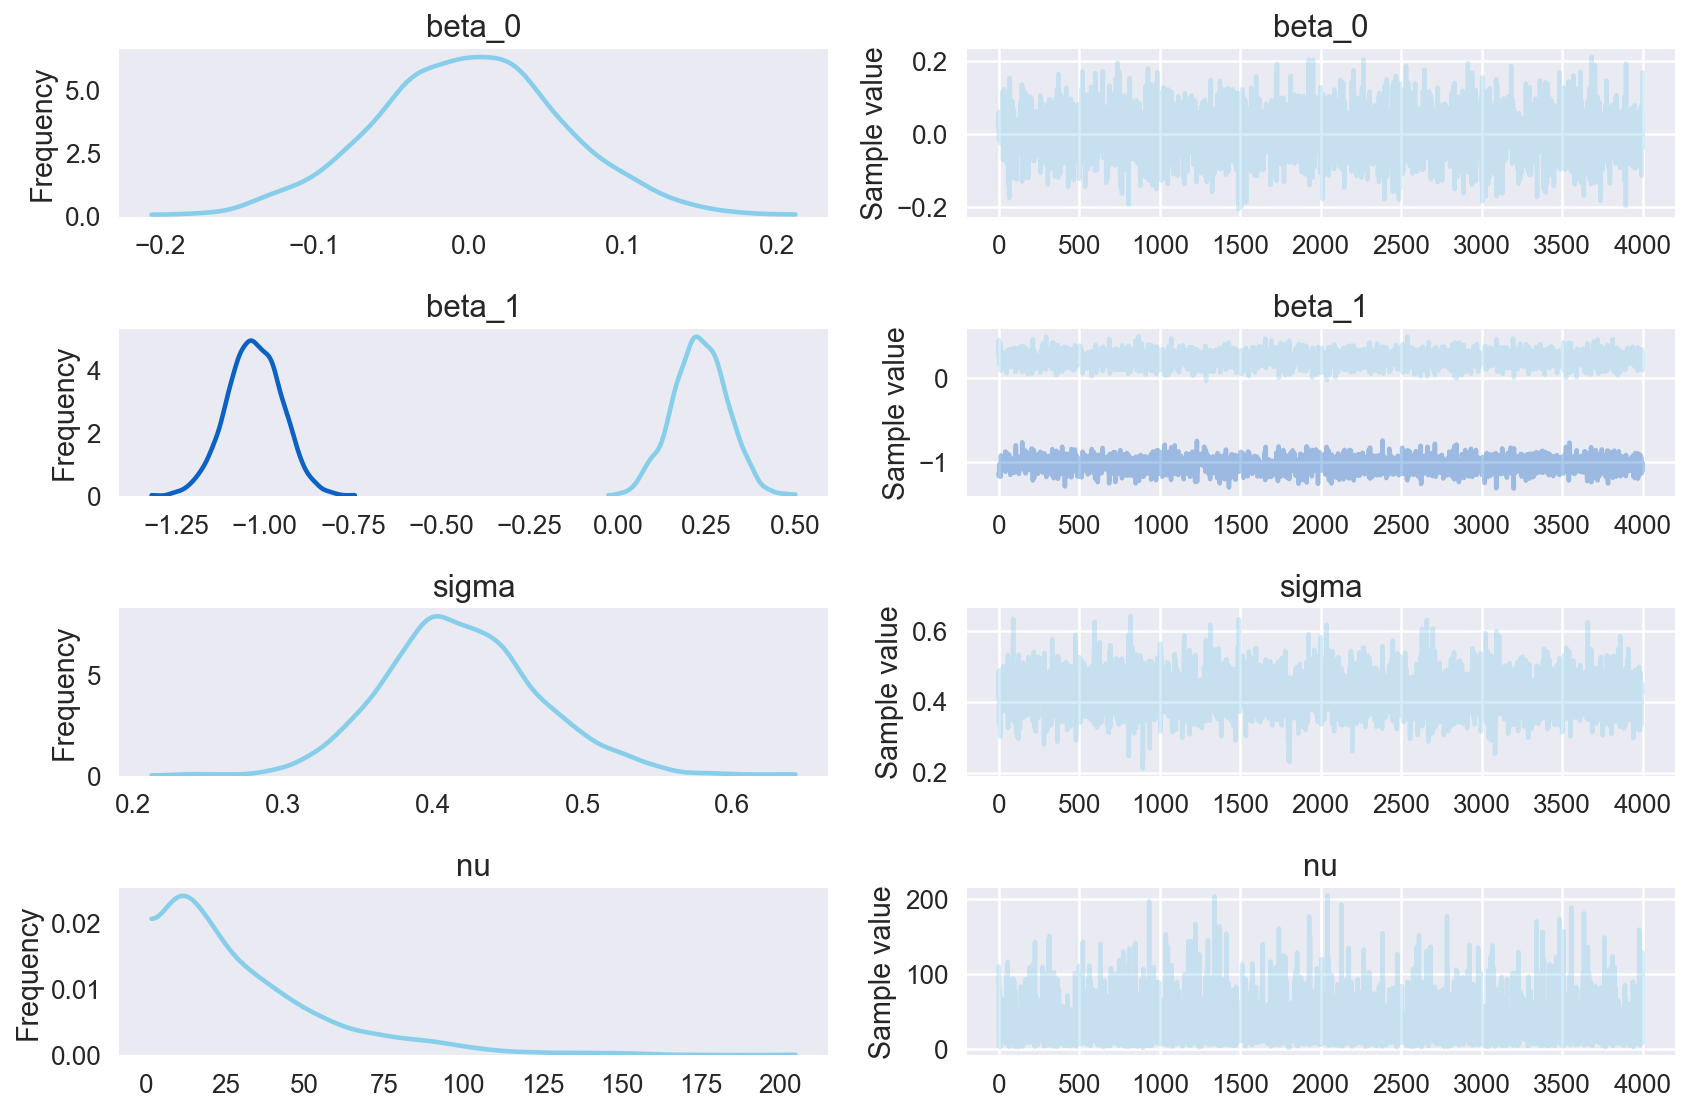

In [6]:
print(pm.df_summary(trace))
pm.traceplot(trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x110c33150>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x110954f90>], dtype=object)

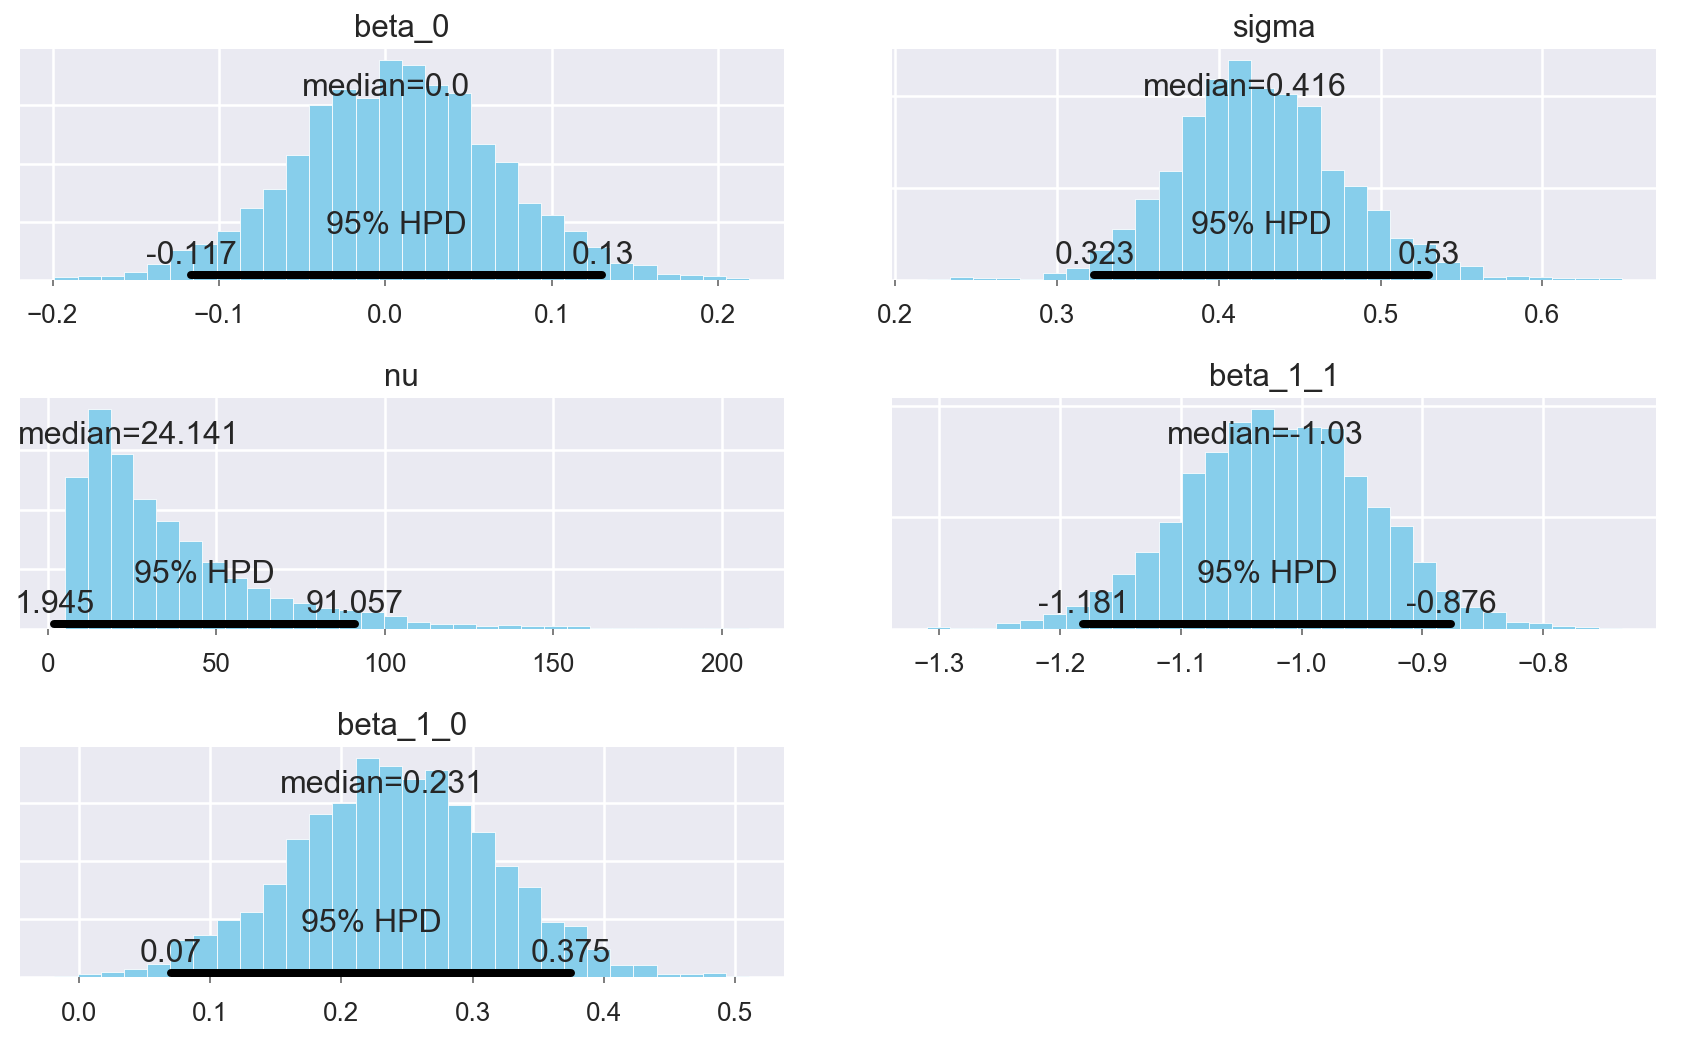

In [7]:
pm.plot_posterior(trace, point_estimate="median")

### Redundant Predictors

In [8]:
X["PropNotTake"] = (100 - X["PrcntTake"]) / 100
X.head()

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,Spend,PrcntTake,PropNotTake
0,4.405,8,0.92
1,8.963,47,0.53
2,4.778,27,0.73
3,4.459,6,0.94
4,4.992,45,0.55


In [9]:
zx_2 = ((X - X.mean().values) / X.std().values).values
zx_2[:5]

array([[-1.10086058, -1.0178453 ,  1.0178453 ],
       [ 2.24370805,  0.4394222 , -0.4394222 ],
       [-0.82716069, -0.30789447,  0.30789447],
       [-1.06123647, -1.09257697,  1.09257697],
       [-0.6701318 ,  0.36469053, -0.36469053]])

In [10]:
# We added that redundant column...
n_cols = 3
with pm.Model() as redundant_model:
    # Priors
    beta_0 = pm.Normal("beta_0", mu=0, tau=1E-8)
    beta_1 = pm.Normal("beta_1", mu=0, tau=1E-8, shape=n_cols)
    theta = beta_0 + tt.dot(beta_1, zx_2.T)

    sigma = pm.HalfCauchy("sigma", 5)    # Gelman 2006
    nu = pm.Exponential("nu", 1.0 / 29)  # Taken from the book
    # Likelihood
    y = pm.StudentT("y", nu=nu, mu=theta, sd=sigma, observed=zy)
    # Sample
    trace = pm.sample(draws=6000, tune=2000, chain=3)

burn_in = 2000
trace = trace[burn_in:]

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -80.237: 100%|██████████| 200000/200000 [00:18<00:00, 10988.46it/s]
Finished [100%]: Average ELBO = -80.25
  0%|          | 1/6000 [00:54<91:16:51, 54.78s/it]

In [ ]:
print(pm.df_summary(trace))
pm.traceplot(trace)

In [ ]:
pm.plot_posterior(trace, point_estimate="mode")